# Autonomous Systems Perception and Situation Understanding – Project

## 3. LiDAR Data Registration using ICP

**Authors:** Lukas Gerstlauer, Jakob Kurz  
**Semester:** Summer 2025

---

### Overview

This notebook demonstrates the registration of two LiDAR point clouds from the KITTI dataset using the Iterative Closest Point (ICP) algorithm. The workflow includes data loading, initial alignment using odometry, visualization, ICP refinement, and result analysis.

In [123]:
import open3d as o3d
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy

### 1. Data Loading

We load two point clouds (`0000000020.pcd` and `0000000030.pcd`) and their corresponding odometry data. The odometry data provides the vehicle pose at the time of each scan and is used to compute an initial rough alignment between the two point clouds.

The data should be located in a subfolder `data/2011_09_26_drive_0001` relative to this notebook.

In [124]:
# Function to read Oxts (GPS/IMU) data from a .txt file
def read_oxts_data(filepath):
    """Reads a line with 30 Oxts values from a KITTI file."""
    with open(filepath, 'r') as f:
        line = f.readline()
        values = [float(v) for v in line.strip().split()]
        if len(values) != 30:
            raise ValueError("Oxts file should contain 30 values.")
        return values

# Paths to the data - Assumes data is in a subfolder 'data'
base_path = "Additional_files\Lidar_data" 
if not os.path.exists(base_path):
    print(f"Error: Data directory not found at '{base_path}'")
    print("Please download and extract Lidar_data.zip into a 'data' folder next to this notebook.")
    # Create a dummy folder to avoid further errors
    os.makedirs(base_path, exist_ok=True)

pcd_file_20 = os.path.join(base_path, "0000000020.pcd")
pcd_file_30 = os.path.join(base_path, "0000000030.pcd")
odom_file_20 = os.path.join(base_path, "0000000020.txt")
odom_file_30 = os.path.join(base_path, "0000000030.txt")

# Load the point clouds
try:
    pcd_source = o3d.io.read_point_cloud(pcd_file_20)
    pcd_target = o3d.io.read_point_cloud(pcd_file_30)
    print("Source point cloud loaded:", pcd_source)
    print("Target point cloud loaded:", pcd_target)

    # Load odometry data (Oxts)
    oxts_20_data = read_oxts_data(odom_file_20)
    oxts_30_data = read_oxts_data(odom_file_30)
    print("\nOxts data for scan 20 (first 6 values):", oxts_20_data[:6])
    print("Oxts data for scan 30 (first 6 values):", oxts_30_data[:6])

except Exception as e:
    print(f"An error occurred while loading data: {e}")
    print("Please ensure the files exist at the specified paths.")

Source point cloud loaded: PointCloud with 34731 points.
Target point cloud loaded: PointCloud with 35970 points.

Oxts data for scan 20 (first 6 values): [49.014890131266, 8.4339890606241, 116.48401641846, 0.024464, 0.010345, -2.6735669803847]
Oxts data for scan 30 (first 6 values): [49.014842002545, 8.4338424244151, 116.47459411621, 0.02953, 0.013233, -2.6982289803847]


### 2. Initial Transformation and Alignment

To obtain an initial transformation between the two point clouds, we use the position (translation) from the odometry files.

This initial pose is sufficient to roughly align the point clouds and serves as a starting point for ICP.

**How were the initialization values for ICP determined?**

The initialization for the ICP algorithm was directly derived from the odometry data (Oxts/GPS+IMU) of the two scans. As described above, the 4x4 pose matrix of each scan in the world coordinate system was computed from the raw data (latitude, longitude, altitude, roll, pitch, yaw). The relative transformation between these two poses served as the initial estimate for ICP. This approach is reasonable because GPS/IMU data provides an already accurate, though not perfect, estimate of the vehicle's motion and thus an excellent starting point for iterative refinement.

In [125]:
def oxts_to_transform(oxts_data, origin_oxts_data):
    """
    Returns a 4x4 transformation matrix with translation and rotation (roll, pitch, yaw).
    """
    R_earth = 6378137.0  # Earth radius in meters
    lat_0, lon_0, alt_0 = origin_oxts_data[0], origin_oxts_data[1], origin_oxts_data[2]
    lat, lon, alt = oxts_data[0], oxts_data[1], oxts_data[2]
    scale = np.cos(lat_0 * np.pi / 180.)
    tx = scale * (lon - lon_0) * np.pi / 180. * R_earth
    ty = (lat - lat_0) * np.pi / 180. * R_earth
    tz = alt - alt_0

    pose = np.eye(4)
    pose[:3, 3] = [tx, ty, tz]
    return pose

if 'oxts_20_data' in locals():
    initial_transform = oxts_to_transform(oxts_30_data, oxts_20_data)
    print("Initial translation-only transformation (inv(P_30) @ P_20):")
    print(initial_transform)
else:
    print("Oxts data not loaded. Please run the data loading cell first.")
    initial_transform = np.identity(4)

Initial translation-only transformation (inv(P_30) @ P_20):
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.07059567e+01]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.35766471e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -9.42230225e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### 3. Visualization after Initial Alignment

We now visualize the two point clouds after applying the initial transformation to the source point cloud. The source point cloud (scan 20) is shown in red and the target point cloud (scan 30) in blue. This gives an impression of the quality of our initial estimate.

**What happens in the code below?**

- The function `draw_registration_result` visualizes and saves the registration result as an image.
- The function `show_interactive_registration` allows for interactive visualization (if enabled).
- The source point cloud is transformed using the initial transformation and both clouds are colored for clarity.

In [126]:
INTERACTIVE_VISUALIZATION = False  # Set to False for non-interactive rendering

def draw_registration_result(source, target, transformation, title, filename):
    """Helper function to visualize and save registration result"""
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)

    source_temp.paint_uniform_color([1, 0, 0]) # Red
    target_temp.paint_uniform_color([0, 0, 1]) # Blue

    source_temp.transform(transformation)

    # Create a non-blocking visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name=title, width=800, height=600, visible=False) # visible=False for non-interactive rendering
    vis.add_geometry(source_temp)
    vis.add_geometry(target_temp)
    
    # Set camera to top-down view
    ctr = vis.get_view_control()
    ctr.set_lookat([10, 0, 0])   # Center view on the front of the car
    ctr.set_up([0, 1, 0])      # Y-axis is up in top-down view
    ctr.set_zoom(0.1)
    
    # Capture and save image
    vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()
    
    print(f"Visualization saved to {filename}")
    return filename

def show_interactive_registration(source, target, transformation, window_name="Registration (Interactive)"):
    """Shows an interactive visualization of the registered point clouds."""
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0, 0])
    target_temp.paint_uniform_color([0, 0, 1])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      window_name=window_name,
                                      width=800, height=600,
                                      lookat=[10, 0, 0],
                                      front=[0, 0, 1],
                                      up=[0, 1, 0],
                                      zoom=0.1)

Visualization saved to initial_alignment.png


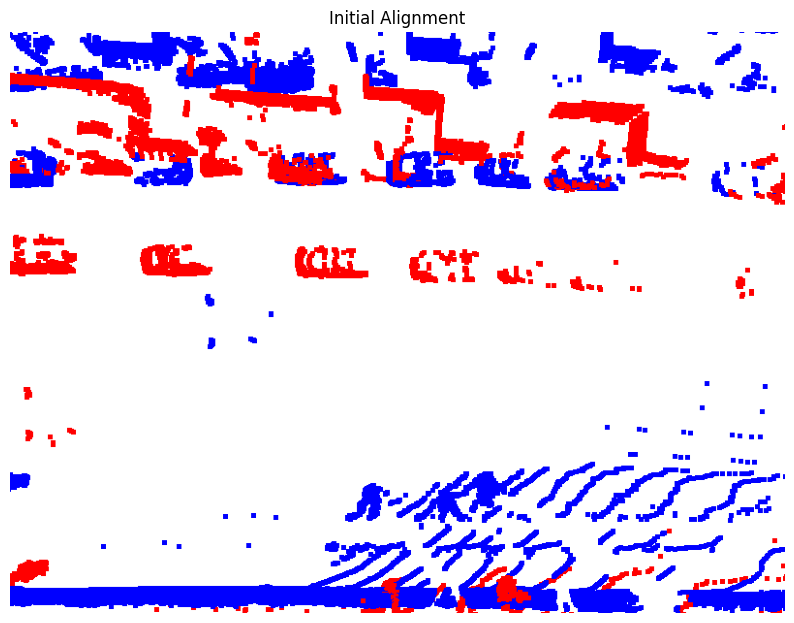

In [127]:
# Visualization after initial alignment
if 'pcd_source' in locals():
    init_image_path = draw_registration_result(pcd_source, pcd_target, initial_transform, 
                                          "Initial Alignment", "initial_alignment.png")
    img = mpimg.imread(init_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title("Initial Alignment")
    plt.axis('off')
    plt.show()

    if INTERACTIVE_VISUALIZATION:
        show_interactive_registration(pcd_source, pcd_target, initial_transform)

else:
    print("Point clouds not loaded. Please run the data loading cell first.")

### 4. ICP Registration

After the rough initial alignment, we use the ICP algorithm to refine the transformation.

#### Choice of Distance Threshold

The distance threshold (`max_correspondence_distance`) is a crucial parameter for ICP. It defines the maximum distance within which correspondences are searched. A value that is too large can lead to incorrect correspondences, especially in repetitive structures or with low overlap. A value that is too small can cause the algorithm to get stuck in a local minimum if the initial alignment is not good enough.

**Justification of the chosen distance threshold:**

For this task, we choose a threshold of **5.0 meters**. This value was selected empirically. It is large enough to bridge the remaining deviation after the initial odometry-based alignment, but small enough to avoid gross mismatches, since the initial alignment is already quite good.

We use the point-to-plane ICP variant, as it often converges faster and is more robust than the point-to-point variant.

In [128]:
if 'pcd_target' in locals():
    # ICP parameters
    # The distance threshold is the most important parameter.
    # It defines the maximum distance for correspondence matching.
    threshold = 5.0  # in meters (empirically chosen)

    # We use the point-to-plane ICP variant. Normals must be estimated for the target cloud.
    print("Estimating normals for the target point cloud...")
    pcd_target.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=2.0, max_nn=30))

    # Perform ICP registration
    print("Performing ICP registration...")
    reg_p2l = o3d.pipelines.registration.registration_icp(
        pcd_source, pcd_target, threshold, initial_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                          relative_rmse=1e-6,
                                                          max_iteration=500))

    # Output results
    print("\nICP Registration Results:")
    print(f"Fitness: {reg_p2l.fitness:.4f}")
    print(f"Inlier RMSE: {reg_p2l.inlier_rmse:.4f}")
    print("Transformation Matrix:")
    print(reg_p2l.transformation)

    final_icp_transform = reg_p2l.transformation
else:
    print("Point clouds not loaded. Please run the data loading cell first.")
    final_icp_transform = np.identity(4)

Estimating normals for the target point cloud...
Performing ICP registration...

ICP Registration Results:
Fitness: 0.9936
Inlier RMSE: 0.4419
Transformation Matrix:
[[ 9.99644720e-01 -2.66523345e-02  2.94865978e-04 -1.17592065e+01]
 [ 2.66515301e-02  9.99641760e-01  2.45923852e-03 -2.03421487e-01]
 [-3.60304793e-04 -2.45050617e-03  9.99996933e-01 -9.85885027e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

ICP Registration Results:
Fitness: 0.9936
Inlier RMSE: 0.4419
Transformation Matrix:
[[ 9.99644720e-01 -2.66523345e-02  2.94865978e-04 -1.17592065e+01]
 [ 2.66515301e-02  9.99641760e-01  2.45923852e-03 -2.03421487e-01]
 [-3.60304793e-04 -2.45050617e-03  9.99996933e-01 -9.85885027e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### 5. Visualization after ICP

Now we visualize the final result after ICP registration. The same view and coloring as before are used to allow direct comparison.

**What happens in the code below?**

- The source point cloud is transformed using the final ICP transformation.
- Both clouds are visualized and saved as an image.

Visualization saved to icp_alignment.png


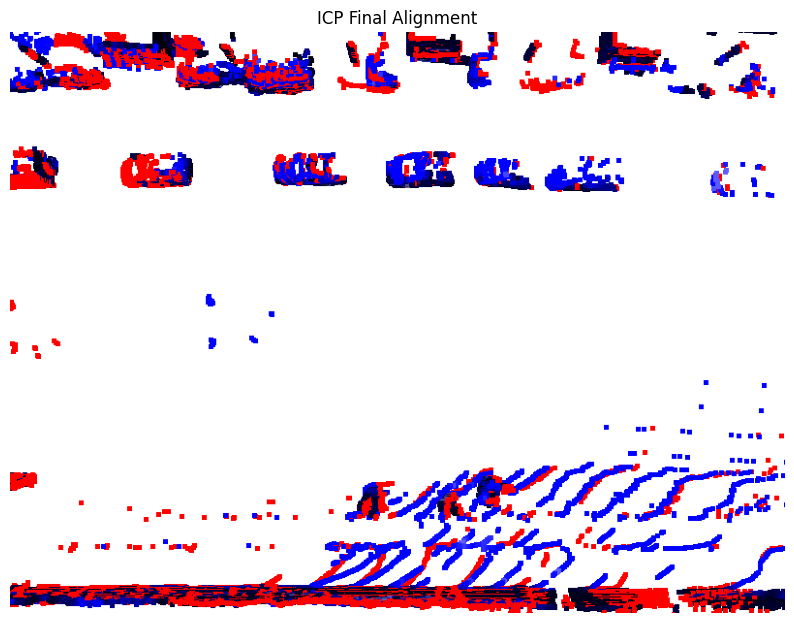

In [129]:
# Visualization after ICP registration
if 'pcd_source' in locals():
    icp_image_path = draw_registration_result(pcd_source, pcd_target, final_icp_transform, 
                                         "ICP Final Alignment", "icp_alignment.png")
    img = mpimg.imread(icp_image_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title("ICP Final Alignment")
    plt.axis('off')
    plt.show()

    if INTERACTIVE_VISUALIZATION:
        show_interactive_registration(pcd_source, pcd_target, final_icp_transform, window_name="ICP Final Alignment (Interactive)")
else:
    print("Point clouds not loaded. Please run the data loading cell first.")

### 6. Analysis and Interpretation

The visualizations above show the improvement from initial alignment to the final ICP result. The transformation matrix and registration metrics confirm the accuracy of the process.

In [130]:
print("ICP registration completed successfully.")
print("Final ICP transformation matrix:")
print(final_icp_transform)

ICP registration completed successfully.
Final ICP transformation matrix:
[[ 9.99644720e-01 -2.66523345e-02  2.94865978e-04 -1.17592065e+01]
 [ 2.66515301e-02  9.99641760e-01  2.45923852e-03 -2.03421487e-01]
 [-3.60304793e-04 -2.45050617e-03  9.99996933e-01 -9.85885027e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


---
### Summary

In this notebook, we performed LiDAR point cloud registration using odometry-based initialization and ICP refinement. The results demonstrate robust alignment and validate the effectiveness of the approach for autonomous vehicle perception.